In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow
from keras.datasets import mnist
import PIL
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization, Reshape
#from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

2022-05-12 16:15:36.696459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 16:15:36.696497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_az_dataset(datasetPath):
    # initialize the list of data and labels
    data = []
    labels = []
    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28))
        # update the list of data and labels
        data.append(image)
        labels.append(label)
        # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [3]:
def load_mnist_dataset():
    # load the MNIST dataset and stack the training data and testing
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return (data, labels)

In [4]:
print("[INFO] loading datasets...")
(azData, azLabels) =load_az_dataset('A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...


In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

In [6]:
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

In [7]:
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
#data = [cv2.resize(image, (32, 32)) for image in data]
data=data.reshape(data.shape[0],28,28,1)
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
#data = np.expand_dims(data, axis=-1)
data /= 255.0

In [8]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

In [9]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}


# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [10]:
print(data.shape)
print(labels.shape)

(442451, 28, 28, 1)
(442451, 36)


In [11]:
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, random_state=42)

In [12]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(353960, 28, 28, 1)
(353960, 36)
(88491, 28, 28, 1)
(88491, 36)


In [47]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy')>=0.95):
          print("\nReached 95% accuracy so cancelling training!")
          self.model.stop_training = True

callbacks = myCallback()

In [13]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1)

In [98]:
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(36, activation='softmax'))

In [100]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [101]:
history = model.fit(aug.flow(trainX, trainY,128), epochs=10, batch_size=128, class_weight=classWeight)

Epoch 1/10
2766/2766 [==============================] - 332s 119ms/step - loss: 2.9283 - accuracy: 0.7881
Epoch 2/10
2766/2766 [==============================] - 200s 72ms/step - loss: 1.5261 - accuracy: 0.8684
Epoch 3/10
2766/2766 [==============================] - 219s 79ms/step - loss: 1.2915 - accuracy: 0.8849
Epoch 4/10
2766/2766 [==============================] - 198s 72ms/step - loss: 1.1714 - accuracy: 0.8948
Epoch 5/10
2766/2766 [==============================] - 192s 69ms/step - loss: 1.0811 - accuracy: 0.9006
Epoch 6/10
2766/2766 [==============================] - 183s 66ms/step - loss: 1.0271 - accuracy: 0.9055
Epoch 7/10
2766/2766 [==============================] - 176s 64ms/step - loss: 0.9693 - accuracy: 0.9090
Epoch 8/10
2766/2766 [==============================] - 374s 135ms/step - loss: 0.9307 - accuracy: 0.9122
Epoch 9/10
2766/2766 [==============================] - 359s 128ms/step - loss: 0.9008 - accuracy: 0.9149
Epoch 10/10
2766/2766 [=============================

In [80]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))


model.add(Dense(36,activation ="softmax"))
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Input 0 of layer "conv2d_20" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
R


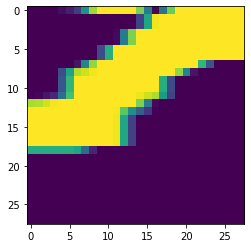

In [106]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#path="/home/yasmine/Téléchargements/maj/"
#for filename in os.listdir(path):
image=cv2.imread("./caracteres/word0/caractere3.png")
#plt.imshow(image)
img_copy = image.copy()
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
plt.imshow(img_final)
img_final =np.reshape(img_final, (1,28,28,1))
print(max(model.predict(img_final)))
img_pred = labelNames[np.argmax(model.predict(img_final))]
print(img_pred)

In [104]:
model.save("modelAZa.model", save_format="h5")

In [44]:
result = model.evaluate(testX, testY)

2766/2766 [==============================] - 33s 7ms/step - loss: 0.3047 - accuracy: 0.8674


In [109]:
model = Sequential()
#model.add(Reshape((28, 28, 1), input_shape=(784,)))
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (4, 4)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('sigmoid'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(36))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 batch_normalization_20 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 21, 21, 32)        16416     
                                                                 
 batch_normalization_21 (Bat  (None, 21, 21, 32)       128       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 21, 21, 32)       

In [110]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

In [111]:
cb_early_stopper = EarlyStopping(monitor='loss', patience=10)
reduce_on_plateau = ReduceLROnPlateau(monitor="accuracy", mode="max", factor=0.1, patience=20, verbose=1)
callback_values = [cb_early_stopper,reduce_on_plateau]

In [ ]:
history = model.fit(aug.flow(trainX, trainY,32), epochs=200, steps_per_epoch=1000, class_weight=classWeight, callbacks=callback_values)

Epoch 1/200
1000/1000 [==============================] - 238s 215ms/step - loss: 16.3485 - accuracy: 0.1113 - lr: 1.0000e-05
Epoch 2/200
1000/1000 [==============================] - 345s 345ms/step - loss: 11.9444 - accuracy: 0.3152 - lr: 1.0000e-05
Epoch 3/200
1000/1000 [==============================] - 322s 322ms/step - loss: 9.5821 - accuracy: 0.4481 - lr: 1.0000e-05
Epoch 4/200
1000/1000 [==============================] - 273s 272ms/step - loss: 8.0644 - accuracy: 0.5272 - lr: 1.0000e-05
Epoch 5/200
1000/1000 [==============================] - 183s 183ms/step - loss: 7.0135 - accuracy: 0.5831 - lr: 1.0000e-05
Epoch 6/200
1000/1000 [==============================] - 171s 169ms/step - loss: 6.1250 - accuracy: 0.6296 - lr: 1.0000e-05
Epoch 7/200
1000/1000 [==============================] - 106s 106ms/step - loss: 5.4732 - accuracy: 0.6631 - lr: 1.0000e-05
Epoch 8/200
1000/1000 [==============================] - 78s 78ms/step - loss: 4.8938 - accuracy: 0.6933 - lr: 1.0000e-05
Epoch 9/

In [61]:
model.save("Newmodel.model", save_format="h5")

In [62]:
result = model.evaluate(testX, testY)

2766/2766 [==============================] - 33s 11ms/step - loss: 0.1934 - accuracy: 0.9147


In [86]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames=[i for i in labelNames ]

z3.jpeg 2
K.jpeg K
8.png 8
a1.jpeg A
hh.jpeg K
r3.jpeg R
1.png J
444.jpeg 4
d.jpeg D
3.png 2
m1.jpeg M
55.png 5
7.png 7
LL.png 2
I.jpeg 1
d1.png 5
999.jpeg 9
n1.jpeg 1
W.png W
e3.png E
b1.jpeg 6
99.png 9
H.png H
333.png 3
22.png 2
1.jpg 8
Y.png V
L1.png 0
44.jpeg 4
a.jpg A
66.png 8
u2.jpeg 4
a3.png A
k1.png K
G.jpeg G
f3.png 7
r1.png 2
z1.png Z
p1.png Y
J.png 2
M.jpeg M
L.png L
d.jpg 5
kk.jpeg K
B.png 5
B1.jpeg 0
h3.jpeg H
9.png 9
tt.jpeg 1
777.png 8
pp.png P
xx.png 4
m.png M
w1.png 4
c1.png 8
6.png 8
q1.png 9
nn.png 7
t2.png T
R.jpeg 5
p3.png 5
b.jpeg 0
a2.jpeg 2
O.jpeg 0
4.png 4
g.png 9
V.jpeg V
2.png 2
u1.png D
b1.png 6
T.png J
o.png 0
S.png S
77.png 2
Z.jpeg Z
f2.png 1
j2.png J
s1.png P
88.png 8
N.jpeg N
h2.jpeg 5
P.jpeg P
i2.png 1
e1.png 0
U.jpeg U
q.png Q
a.png A
g1.png 8
e2.jpeg 2
q2.png 9
c2.png C
dd.png 3
t1.png 1
888.png B
y2.png 5
7777.png 2
y.png 8
f1.png 1
X.jpeg X
w3.png M
C.jpeg G
E.png E
h1.png 7
yy.jpeg 4
v3.jpeg 8
b2.jpeg B
x1.png 5
v1.png 5
j1.png 1
i1.png 1
v2.png 4

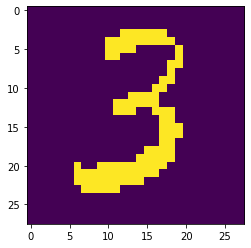

In [107]:

path="/home/yasmine/Téléchargements/maj/"
for filename in os.listdir(path):
    image=cv2.imread(path+filename)
    img_copy = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #img_copy = cv2.GaussianBlur(img_copy, (3,3), 0)
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    #plt.imshow(img_gray)
    img_copy = cv2.resize(img_gray, (28,28))
    _, img_thresh = cv2.threshold(img_copy, 190, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(img_thresh )
    #img_final = cv2.resize(img_thresh, (28,28))

    img_final =img_thresh .reshape(1,28,28,1)
    #plt.imshow(img_final)
    data = np.array(img_final, dtype="float32")
    data /= 255.0
    img_pred = labelNames[np.argmax(model.predict(data))]
    
    print(filename,img_pred)

D


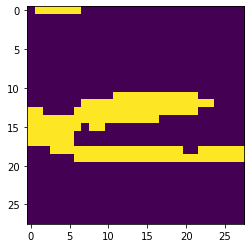

In [97]:
image=cv2.imread("./caracteres/word0/caractere1.png")
img_copy = image.copy()
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_copy = cv2.GaussianBlur(img_copy, (5,5), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray)
img_copy = cv2.resize(img_gray, (28,28))
_, img_thresh = cv2.threshold(img_copy, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_thresh )
#img_final = cv2.resize(img_thresh, (28,28))

img_final =img_thresh .reshape(1,28,28,1)
#plt.imshow(img_final)
data = np.array(img_final, dtype="float32")
data /= 255.0
img_pred = labelNames[np.argmax(model.predict(data))]
print(img_pred)

In [35]:
img_pred = labelNames[np.argmax(model.predict(img_final))]
print(img_pred)

C


In [28]:
print(model.predict(img_final))

[[0.04128188 0.04353632 0.02983284 0.03228798 0.04521467 0.04777106
  0.04043522 0.03976554 0.02018813 0.05026819 0.03352798 0.05249602
  0.0121046  0.02570948 0.01458274 0.11177649 0.03431619 0.02794745
  0.04586308 0.05581767 0.00752654 0.01802094 0.01198805 0.02978308
  0.0918838  0.03607408]]


In [18]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#an_image = PIL.Image.open(path+filename)
#grayImage= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image=cv2.imread("/home/yasmine/Téléchargements/maj/K.jpeg")
#an_image = PIL.Image.open(path+filename)
grayImage= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image=cv2.resize(grayImage, (28,28))

d = np.array(image, dtype="float32")
#data = np.expand_dims(data, axis=-1)
d /= 255.0
print(d.shape)

(28, 28)


In [ ]:
proba=model.predict(d.reshape(1,28,28,1))
print(labelNames[np.argmax(proba)])

In [19]:
proba=model.predict(d.reshape(1,28,28,1))
print(labelNames[np.argmax(proba)])

B


In [5]:
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}


# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]



In [6]:
print(data.shape)
print(labels.shape)

(442451, 32, 32, 1)
(442451, 36)


In [7]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, stratify=labels, random_state=42)

In [8]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(353960, 32, 32, 1)
(353960, 36)
(88491, 32, 32, 1)
(88491, 36)


In [9]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1)

In [9]:
model=Sequential()
model.add((Conv2D(60,(5,5),input_shape=(32,32,1),activation="relu")))
model.add((Conv2D(60,(5,5),activation="relu")))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add((Conv2D(60//2,(3,3),activation="relu")))
model.add((Conv2D(60//2,(3,3),activation="relu")))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(36,activation="softmax"))
model.compile(Adam(lr=0.001),loss='categorical_crossentropy',  metrics=['accuracy'])

2022-05-07 14:18:24.907869: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-07 14:18:24.966878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yasmine-Lenovo-ideapad-130-15IKB): /proc/driver/nvidia/version does not exist
2022-05-07 14:18:25.770083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yasmine/jupyter/environment/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
history = model.fit(aug.flow(trainX, trainY,50),  epochs=8, steps_per_epoch=1000, shuffle=1)

Epoch 1/10


2022-05-07 14:20:03.001967: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19975680 exceeds 10% of free system memory.
2022-05-07 14:20:03.007391: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23328000 exceeds 10% of free system memory.
2022-05-07 14:20:03.012730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19975680 exceeds 10% of free system memory.
2022-05-07 14:20:03.013258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23328000 exceeds 10% of free system memory.
2022-05-07 14:20:03.034385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27648000 exceeds 10% of free system memory.


2000/2000 [==============================] - 976s 473ms/step - loss: 0.9093 - accuracy: 0.7380 - val_loss: 0.2183 - val_accuracy: 0.9318
Epoch 2/10
2000/2000 [==============================] - 800s 400ms/step - loss: 0.4412 - accuracy: 0.8693 - val_loss: 0.1666 - val_accuracy: 0.9468
Epoch 3/10
2000/2000 [==============================] - 552s 276ms/step - loss: 0.3659 - accuracy: 0.8917 - val_loss: 0.1659 - val_accuracy: 0.9487
Epoch 4/10
2000/2000 [==============================] - 557s 278ms/step - loss: 0.3288 - accuracy: 0.9021 - val_loss: 0.1483 - val_accuracy: 0.9543
Epoch 5/10
2000/2000 [==============================] - 535s 268ms/step - loss: 0.3068 - accuracy: 0.9090 - val_loss: 0.1455 - val_accuracy: 0.9553
Epoch 6/10
2000/2000 [==============================] - 547s 273ms/step - loss: 0.2976 - accuracy: 0.9123 - val_loss: 0.1367 - val_accuracy: 0.9587
Epoch 7/10
2000/2000 [==============================] - 512s 256ms/step - loss: 0.2835 - accuracy: 0.9153 - val_loss: 0.131

In [11]:
model.save("model1.model", save_format="h5")

In [11]:
model1 = load_model('model1.model')


In [21]:
predicted_labels = model.predict(testX)
#testY = testY.argmax(axis=1)

print("accuracy_test",accuracy_score(testY, predicted_labels))
cm=confusion_matrix(testY, predicted_labels)
print(classification_report(testY, predicted_labels))

plt.figure(figsize=(16,16))
ax= plt.subplot()
sns.heatmap(cm, fmt='g',annot=True, ax = ax,cmap=plt.cm.Blues) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [10]:
model=Sequential()
model.add((Conv2D(60,(5,5),input_shape=(32,32,1),activation="relu")))
model.add((Conv2D(60,(5,5),activation="relu")))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add((Conv2D(60//2,(3,3),activation="relu")))
model.add((Conv2D(60//2,(3,3),activation="relu")))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(36,activation="softmax"))
model.compile(Adam(lr=0.001),loss='categorical_crossentropy',  metrics=['accuracy'])

2022-05-08 13:43:42.370417: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-08 13:43:42.474688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yasmine-Lenovo-ideapad-130-15IKB): /proc/driver/nvidia/version does not exist
2022-05-08 13:43:44.574998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yasmine/jupyter/environment/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(aug.flow(trainX, trainY,50), validation_data=(testX, testY), epochs=20, steps_per_epoch=3000, class_weight=classWeight, shuffle=1)

Epoch 1/20


2022-05-08 13:46:26.594470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19975680 exceeds 10% of free system memory.
2022-05-08 13:46:26.594651: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19975680 exceeds 10% of free system memory.
2022-05-08 13:46:26.600529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23328000 exceeds 10% of free system memory.
2022-05-08 13:46:26.600706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23328000 exceeds 10% of free system memory.
2022-05-08 13:46:26.628662: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27648000 exceeds 10% of free system memory.


3000/3000 [==============================] - ETA: 0s - loss: 4.7383 - accuracy: 0.6598

In [11]:
model.save("model2.model", save_format="h5")

In [19]:
model2 = load_model('model2.model')

accuracy_test 0.8594546338045677
              precision    recall  f1-score   support

           0       0.12      0.96      0.22      1381
           1       0.98      0.96      0.97      1575
           2       0.86      0.97      0.91      1398
           3       0.97      0.99      0.98      1428
           4       0.83      0.97      0.89      1365
           5       0.61      0.87      0.71      1263
           6       0.96      0.96      0.96      1375
           7       0.96      0.98      0.97      1459
           8       0.96      0.96      0.96      1365
           9       0.98      0.97      0.97      1392
          10       0.98      0.99      0.99      2774
          11       0.98      0.98      0.98      1734
          12       0.99      0.98      0.98      4682
          13       0.92      0.95      0.93      2027
          14       0.99      0.98      0.99      2288
          15       0.95      0.99      0.97       232
          16       0.94      0.95      0.95     

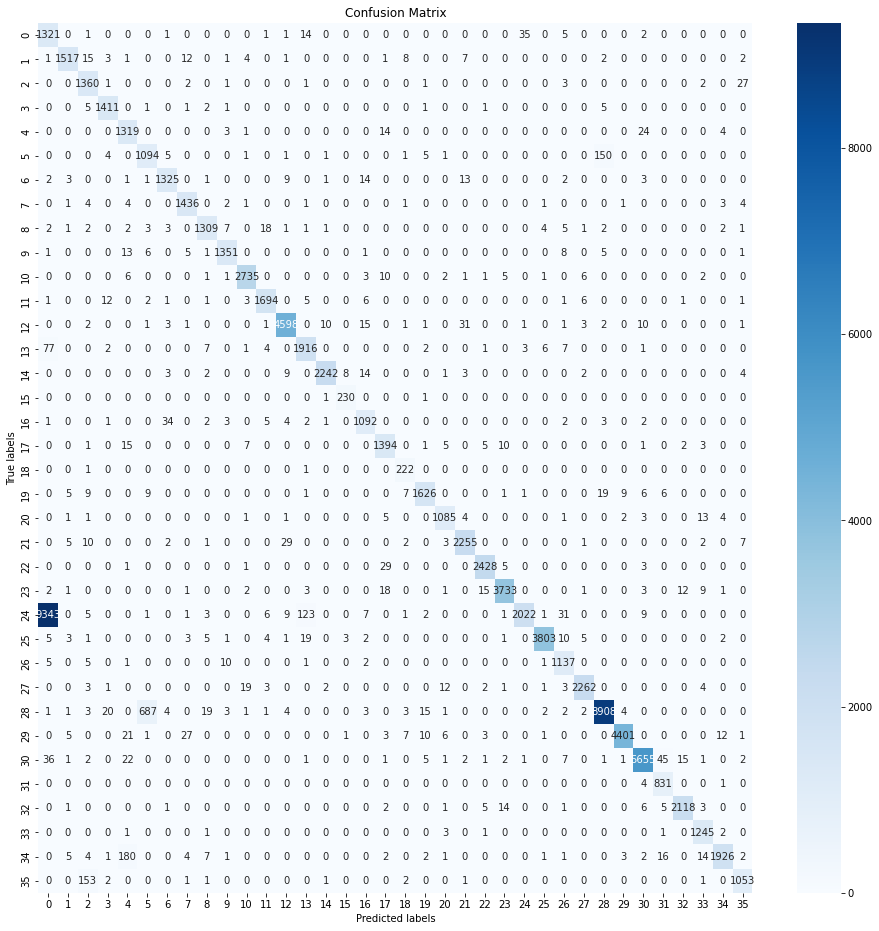

In [20]:
predicted_labels = model2.predict(testX).argmax(axis=1)
#testY = testY.argmax(axis=1)

print("accuracy_test",accuracy_score(testY, predicted_labels))
cm=confusion_matrix(testY, predicted_labels)
print(classification_report(testY, predicted_labels))

plt.figure(figsize=(16,16))
ax= plt.subplot()
sns.heatmap(cm, fmt='g',annot=True, ax = ax,cmap=plt.cm.Blues) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()


In [29]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

21
L


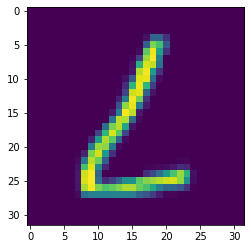

In [33]:
#print(testX[0].shape)
plt.imshow(testX[100])
print(testY[100])
proba=model2.predict(testX[100].reshape(1,32,32,1))
print(labelNames[np.argmax(proba)])

In [15]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model=define_model()
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)